# K-SVD implementation for image denoising

In [1]:
from PIL import Image
import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision 
from dataclasses import dataclass
plt.style.use('ggplot')  # Substitute 'pyor' if it's an actual library style


In [2]:
import os
# get current working directory
current_path = os.getcwd()
print(current_path)
# if not current_path.endswith('PyKSVD'):
if not current_path.endswith('PyKSVD'):
    os.chdir('..')
    current_path = os.getcwd()
    print(current_path)

/Users/mathiasgrau/Documents/ECOLE/MVA/time_series/PyKSVD/notebooks
/Users/mathiasgrau/Documents/ECOLE/MVA/time_series/PyKSVD


## Importing the training dataset

In [3]:
@dataclass
class KSVDConfig:
    K = 441 #441 # the number of atoms in the dictionary
    T0 = 10 #10
    block_patch_size = 8  # the size of the block patch
    image_size = 256 #256  # the generated image resolution
    num_epochs = 80
    output_dir = "../images/ksvd_images"  # the model name locally and on the HF Hub
    seed = 0
    dataset_name = "data/train"
    test_dataset_name = "data/test"
    max_samples = 11000 #11000  # the maximum number of samples to use for training

config = KSVDConfig()
config.n = config.block_patch_size ** 2  # the size of the block patch

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
        # tranform from RGB to grayscale
        transforms.Grayscale(num_output_channels=1),
    ]
)
dataset = torchvision.datasets.ImageFolder(config.dataset_name, preprocess)
dataset

Dataset ImageFolder
    Number of datapoints: 34
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
               Grayscale(num_output_channels=1)
           )

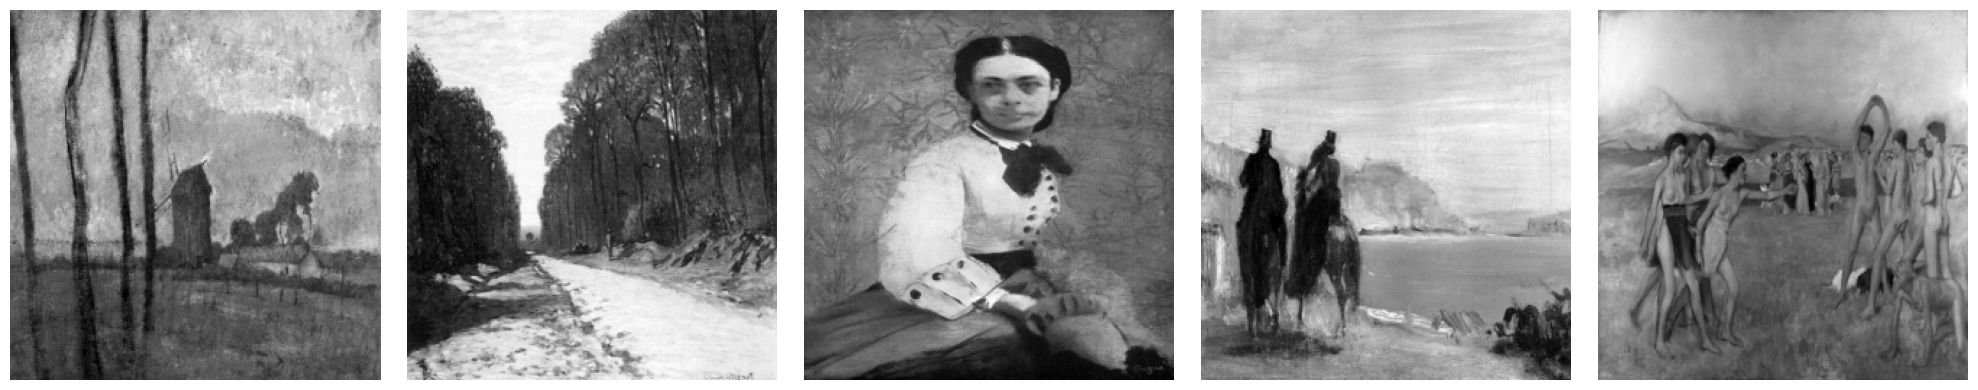

In [4]:

# plot the first 5 images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    img, _ = dataset[i]
    ax = axs[i]
    ax.imshow(img[0], cmap="gray")
    ax.axis("off")
plt.tight_layout()


In [5]:
# first image in the dataset
img, _ = dataset[0]
img = img[0].numpy()
img.shape

(256, 256)

## Creating patches for future training

In [6]:
# for all images in the dataset, extract non-overlapping patches of size 8x8, and stack them in a matrix
patches = []
patch_size = config.block_patch_size  # Assuming patch size is 8

for img, _ in tqdm(dataset):
    img = img[0].numpy()  # Extract the numpy array from the tensor

    # Iterate over the image in steps of patch_size
    for i in range(0, config.image_size, patch_size):
        for j in range(0, config.image_size, patch_size):
            # Extract the patch
            patch = img[i : i + patch_size, j : j + patch_size]

            # Ensure the patch is exactly patch_size x patch_size
            if patch.shape == (patch_size, patch_size):
                patches.append(patch)

# Convert the list of patches to a numpy array
patches = np.array(patches)
print(patches.shape)

  0%|          | 0/34 [00:00<?, ?it/s]

(34816, 8, 8)


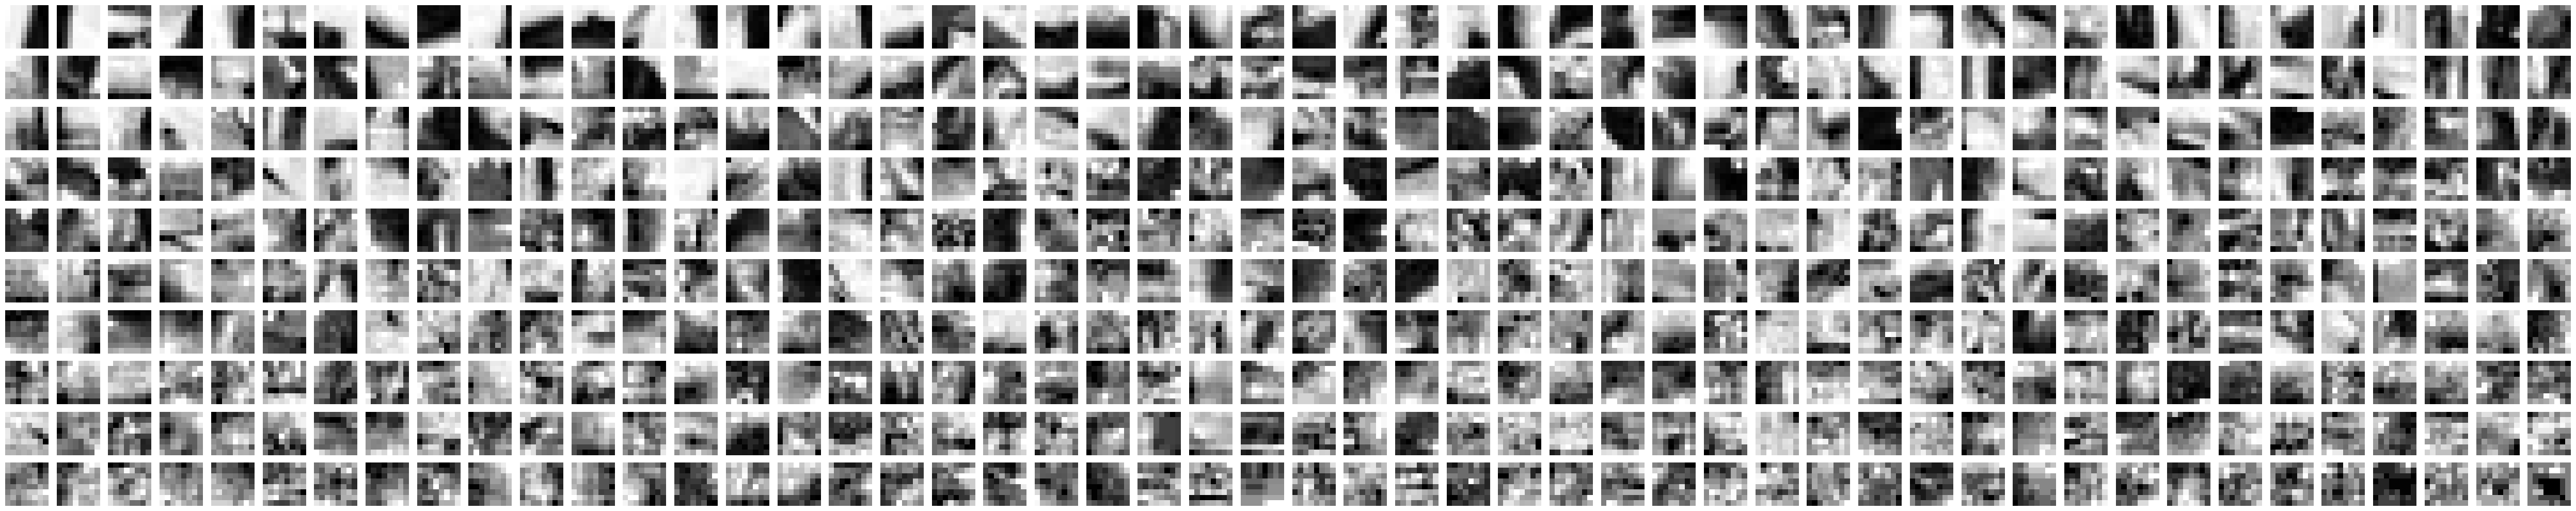

In [7]:
np.random.seed(config.seed)
idx = np.random.choice(len(patches), 500, replace=False)
sorted_idx = np.argsort(patches[idx].var(axis=(1, 2)))[::-1]

fig, axs = plt.subplots(10, 50, figsize=(50, 10))  # Create a 10x50 grid for plotting
for i, ax in enumerate(axs.flatten()):
    if i < 500:
        patch = patches[idx[sorted_idx[i]]]
        ax.imshow(patch, cmap="gray")
        ax.axis("off")
    else:
        ax.remove()  # Remove extra axes
plt.tight_layout()
plt.show()


In [8]:
# Flatten the patches to a 2D matrix
Y = patches.reshape(-1, config.n)
# Y is shape N,n transform it to n, N
Y = Y.T
print(Y.shape)
# split Y into Y_train and Y_test

Y = Y[:, :min(config.max_samples, Y.shape[1])]
number_of_samples = Y.shape[1]
# Y_train = Y[:, : int(0.8 * number_of_samples)]
# Y_test = Y[:, int(0.8 * number_of_samples) :]
Y_train = Y
config.N_train = Y_train.shape[1]
print(f"There are {config.N_train} training samples, of signal length {config.n}")  

(64, 34816)
There are 11000 training samples, of signal length 64


## Implementation of the K-SVD

### Training

In [9]:
from pyksvd.pyksvd import KSVD


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/mathiasgrau/miniconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/mathiasgrau/miniconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/mathiasgrau/miniconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start(

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/mathiasgrau/miniconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/mathiasgrau/miniconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/mathiasgrau/miniconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start(

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



#### Normal K-SVD

In [10]:
# import warnings
# # Suppress all RuntimeWarnings (or a specific message) globally in the script
# warnings.filterwarnings("ignore", category=RuntimeWarning)

In [11]:
ksvd_model = KSVD(K = config.K, T0 = config.T0, max_iter=config.num_epochs)
ksvd_model.fit(Y_train)

Fitting model ...
Initial error: 359.0337


Current error: 359.0337:   0%|          | 0/80 [00:00<?, ?it/s]

Current error: 32.3046:   1%|▏         | 1/80 [00:04<06:24,  4.87s/it]

Error at iteration 1: 32.5096 > 32.3046; skipping update
Final error after fitting: 32.3046


In [12]:
X_train,D = ksvd_model.transform(Y_train)

Transforming data ...
Error after transformation: 32.5096


In [13]:
# patch reconstruction using the learned dictionary
patched_dict = ksvd_model.D.T
patched_dict = patched_dict.reshape(config.K, config.block_patch_size, config.block_patch_size)
patched_dict.shape

(441, 8, 8)

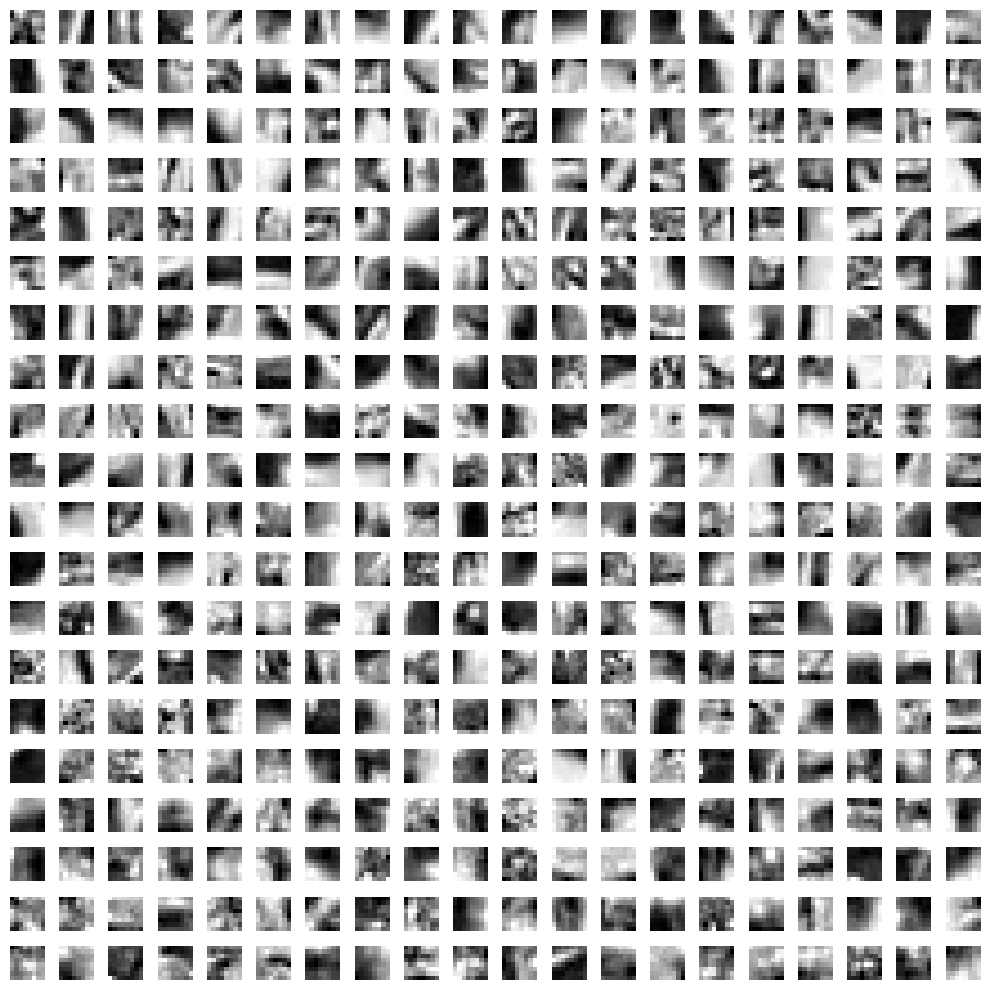

In [14]:
# plot the patches sorted by variance in a 20*20 grid sorted by variance
sorted_idx = np.argsort(patched_dict.var(axis=(1, 2)))[::-1]

fig, axs = plt.subplots(20, 20, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    if i < config.K:
        patch = patched_dict[sorted_idx[i]]
        ax.imshow(patch, cmap="gray")
        ax.axis("off")
    else:
        ax.remove()  # Remove extra axes
plt.tight_layout()
plt.show()



##### Testing on one test noised image

##### From patch to image and reverse 

(256, 256)


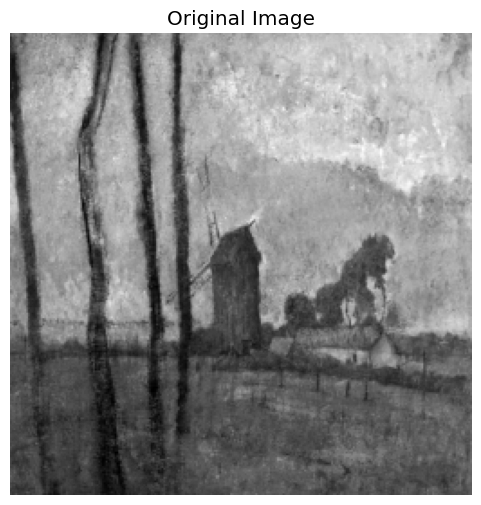

In [15]:
# select on test image from the test set
test_image = dataset[0][0][0].numpy()
print(test_image.shape)
# show 
plt.figure(figsize=(6, 6))
plt.imshow(test_image, cmap="gray")
plt.axis("off")
plt.title("Original Image")
plt.show()


Patches shape: (1024, 8, 8)
Y_test shape: (64, 1024)
Reconstructed patches shape: (1024, 8, 8)


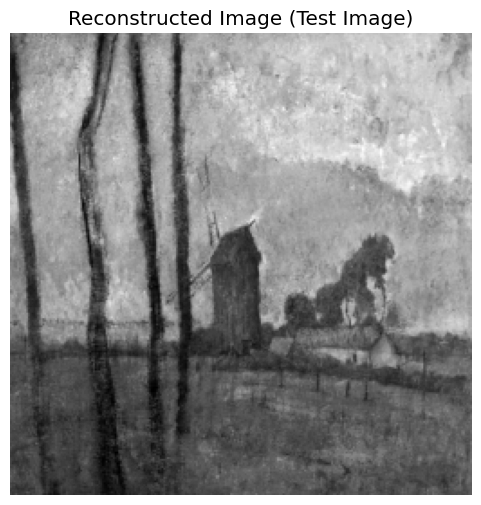

In [16]:
# extract patches from the test image
patches = []
patch_size = config.block_patch_size  # Assuming patch size is 8

for i in range(0, config.image_size, patch_size):
    for j in range(0, config.image_size, patch_size):
        patch = test_image[i : i + patch_size, j : j + patch_size]
        if patch.shape == (patch_size, patch_size):
            patches.append(patch)

# Convert the list of patches to a numpy array
patches = np.array(patches)
print(f"Patches shape: {patches.shape}")  # Should be (num_patches, patch_size, patch_size)

# Flatten the patches to a 2D matrix
Y_test = patches.reshape(patches.shape[0], -1).T  # Shape (patch_size*patch_size, num_patches)
print(f"Y_test shape: {Y_test.shape}")  # Should be (patch_size * patch_size, num_patches)

# Reconstruct the test image using the learned dictionary
# For simplicity, assume reconstructed_patches = Y_test.T reshaped back
reconstructed_patches = Y_test.T.reshape(-1, patch_size, patch_size)
print(f"Reconstructed patches shape: {reconstructed_patches.shape}")

# Create an empty array for the reconstructed image
reconstructed_image = np.zeros((config.image_size, config.image_size), dtype=np.float32)

# Counter for the patches
patch_idx = 0
for i in range(0, config.image_size, patch_size):
    for j in range(0, config.image_size, patch_size):
        if patch_idx < len(reconstructed_patches):  # Ensure no index out of range
            reconstructed_image[i : i + patch_size, j : j + patch_size] = reconstructed_patches[patch_idx]
            patch_idx += 1

# Display the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed_image, cmap="gray")
plt.title("Reconstructed Image (Test Image)")
plt.axis("off")
plt.show()


Transforming data ...
Error after transformation: 9.6810


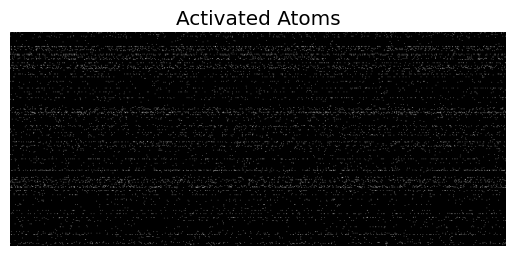

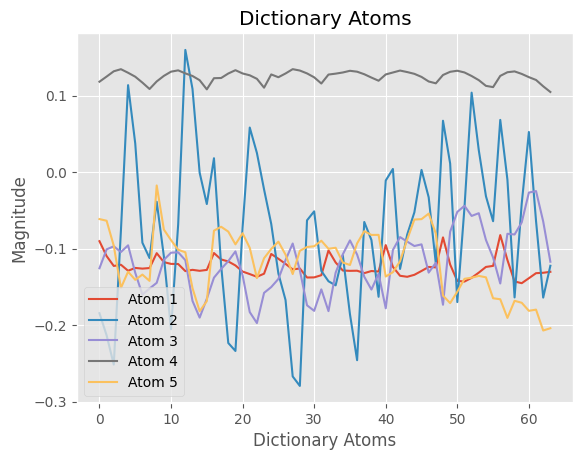

array([10, 10, 10, ..., 10,  9, 10])

In [17]:
X_test, D = ksvd_model.transform(Y_test)
activated = np.where(X_test != 0, 1, 0)
plt.imshow(activated, cmap="gray")
plt.axis("off")
plt.title("Activated Atoms")
plt.show()

activated.sum(axis=0)

# plot the dictionary
plt.figure()
plt.plot(D[:, :5])
plt.title("Dictionary Atoms")
plt.xlabel("Dictionary Atoms")
plt.ylabel("Magnitude")
plt.legend(["Atom 1", "Atom 2", "Atom 3", "Atom 4", "Atom 5"])
plt.show()

activated.sum(axis=0)

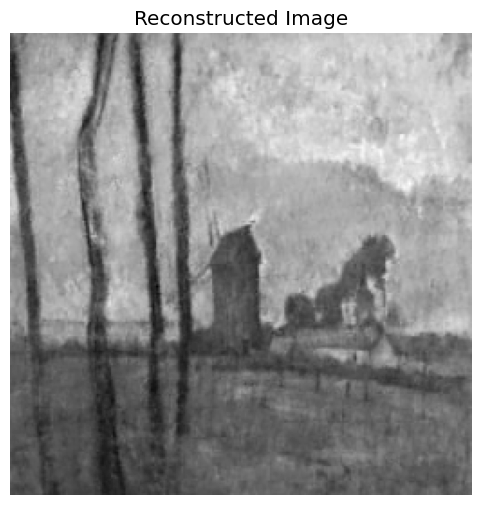

In [18]:

Y_reconstructed_with_dict = ksvd_model.D @ X_test
# Reconstruct the test image using the learned dictionary

reconstructed_patches_with_dict = Y_reconstructed_with_dict.T.reshape(-1, patch_size, patch_size)

reconstructed_image_with_dict = np.zeros((config.image_size, config.image_size), dtype=np.float32)

patch_idx = 0
for i in range(0, config.image_size, patch_size):
    for j in range(0, config.image_size, patch_size):
        if patch_idx < len(reconstructed_patches_with_dict):  # Ensure no index out of range
            reconstructed_image_with_dict[i : i + patch_size, j : j + patch_size] = reconstructed_patches_with_dict[patch_idx]
            patch_idx += 1

# Display the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed_image_with_dict, cmap="gray")
plt.title("Reconstructed Image")
plt.axis("off")
plt.show()


#### New methods where one activation is for the mean

In [19]:
ksvd_model_with_mean = KSVD(K = config.K, T0 = config.T0, max_iter=config.num_epochs)
ksvd_model_with_mean.fit_with_mean(Y_train)

Fitting model with mean ...


Current error: 116.6501:   0%|          | 0/80 [00:03<?, ?it/s]

Converged at iteration 0, delta: 0.0000
Final error after fitting: 116.6501


In [20]:
X_train_with_mean,D_with_mean = ksvd_model_with_mean.transform(Y_train)

Transforming data ...
Error after transformation: 31.4636


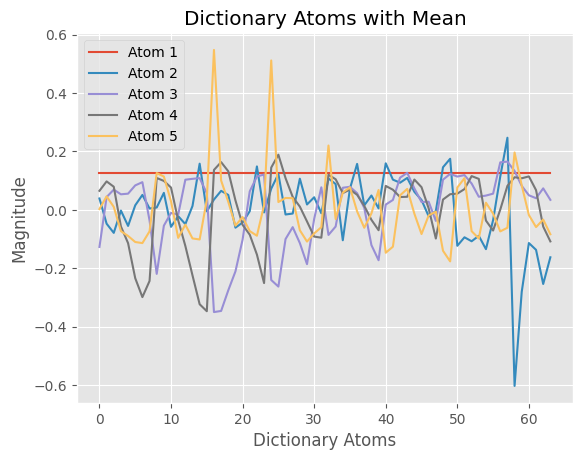

In [21]:
plt.figure()
plt.plot(D_with_mean[:, :5])
plt.title("Dictionary Atoms with Mean")
plt.xlabel("Dictionary Atoms")
plt.ylabel("Magnitude")
plt.legend(["Atom 1", "Atom 2", "Atom 3", "Atom 4", "Atom 5"])  
plt.show()


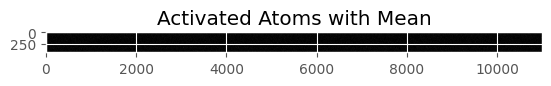

array([10,  9, 10, 10, 10,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [22]:
activated_with_mean = np.where(X_train_with_mean != 0, 1, 0)
plt.figure()
plt.imshow(activated_with_mean, cmap="gray")
plt.title("Activated Atoms with Mean")
plt.show()

activated_with_mean.sum(axis=0)[:15]

In [23]:
X_test_with_mean, D_with_mean = ksvd_model_with_mean.transform(Y_test)

Transforming data ...
Error after transformation: 9.1666


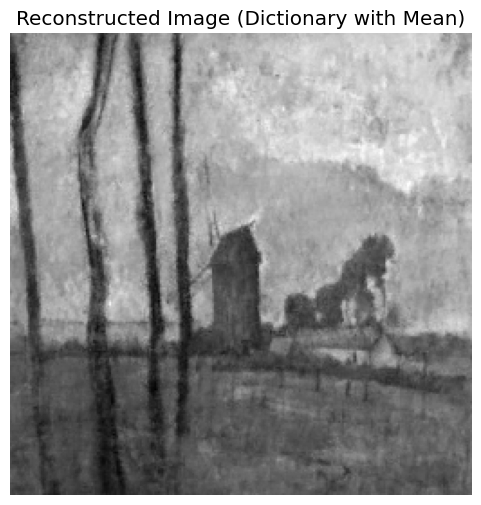

In [24]:
# Reconstruct the test image using the learned dictionary
Y_reconstructed_with_mean = ksvd_model_with_mean.D @ X_test_with_mean
reconstructed_patches_with_mean = Y_reconstructed_with_mean.T.reshape(-1, patch_size, patch_size)
reconstructed_image_with_mean = np.zeros((config.image_size, config.image_size), dtype=np.float32)

patch_idx = 0
for i in range(0, config.image_size, patch_size):
    for j in range(0, config.image_size, patch_size):
        if patch_idx < len(reconstructed_patches_with_mean):  # Ensure no index out of range
            reconstructed_image_with_mean[i : i + patch_size, j : j + patch_size] = reconstructed_patches_with_mean[patch_idx]
            patch_idx += 1

# Display the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed_image_with_mean, cmap="gray")
plt.title("Reconstructed Image (Dictionary with Mean)")
plt.axis("off")
plt.show()


## Test on a new image with noise and missing pixels

(256, 256)
(256, 256)


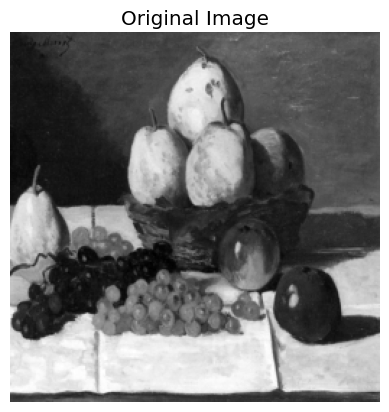

In [25]:
test_dataset = torchvision.datasets.ImageFolder(config.test_dataset_name, preprocess)
test_image = test_dataset[0][0][0].numpy()
print(test_image.shape)
print(test_image.shape)
# show
plt.imshow(test_image, cmap="gray")
plt.axis("off")
plt.title("Original Image")
plt.show()

Patches shape: (1024, 8, 8)
Transforming data ...
Error after transformation: 56.6604
Transforming data ...
Error after transformation: 49.4773
(64, 1024)
Error after transformation: 98.4952


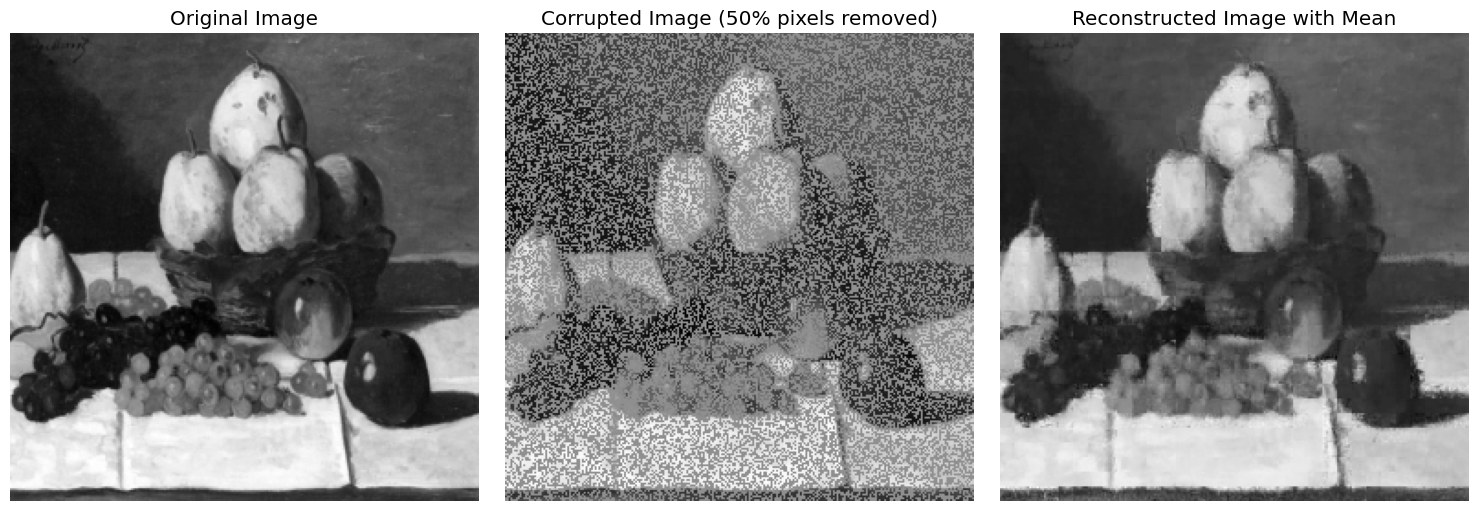

In [26]:
# alterate the test image removing pixels 

REMOVE_PIXELS = 0.5
corrupted_image = test_image.copy()
corrupted_image[np.random.random(corrupted_image.shape) < REMOVE_PIXELS] = 0


# extract patches from the corrupted image
patches = []
patch_size = config.block_patch_size  # Assuming patch size is 8

for i in range(0, config.image_size, patch_size):
    for j in range(0, config.image_size, patch_size):
        patch = corrupted_image[i : i + patch_size, j : j + patch_size]
        if patch.shape == (patch_size, patch_size):
            patches.append(patch)

# Convert the list of patches to a numpy array
patches = np.array(patches)
print(f"Patches shape: {patches.shape}")  # Should be (num_patches, patch_size, patch_size)

# Flatten the patches to a 2D matrix
Y_corrupted = patches.reshape(patches.shape[0], -1).T  # Shape (patch_size*patch_size, num_patches)

# Reconstruct the corrupted image using the learned dictionary
X_corrupted, D = ksvd_model.transform(Y_corrupted)
Y_reconstructed_corrupted = ksvd_model.D @ X_corrupted
reconstructed_patches_corrupted = Y_reconstructed_corrupted.T.reshape(-1, patch_size, patch_size)
reconstructed_image_corrupted = np.zeros((config.image_size, config.image_size), dtype=np.float32)

patch_idx = 0
for i in range(0, config.image_size, patch_size):
    for j in range(0, config.image_size, patch_size):
        if patch_idx < len(reconstructed_patches_corrupted):  # Ensure no index out of range
            reconstructed_image_corrupted[i : i + patch_size, j : j + patch_size] = reconstructed_patches_corrupted[patch_idx]
            patch_idx += 1



# Reconstruct the corrupted image using the learned dictionary with mean
X_corrupted_with_mean, D_with_mean = ksvd_model_with_mean.transform(Y_corrupted)
Y_reconstructed_corrupted_with_mean = ksvd_model_with_mean.D @ X_corrupted_with_mean
reconstructed_patches_corrupted_with_mean = Y_reconstructed_corrupted_with_mean.T.reshape(-1, patch_size, patch_size)
reconstructed_image_corrupted_with_mean = np.zeros((config.image_size, config.image_size), dtype=np.float32)

patch_idx = 0
for i in range(0, config.image_size, patch_size):
    for j in range(0, config.image_size, patch_size):
        if patch_idx < len(reconstructed_patches_corrupted_with_mean):  # Ensure no index out of range
            reconstructed_image_corrupted_with_mean[i : i + patch_size, j : j + patch_size] = reconstructed_patches_corrupted_with_mean[patch_idx]
            patch_idx += 1
            

print(Y_corrupted.shape)
X_corrupted_with_mean_non_null_pixels, D_with_mean = ksvd_model_with_mean.transform_with_mean_signal_with_null_values(Y_corrupted)
Y_reconstructed_corrupted_with_mean_non_null_pixels = ksvd_model_with_mean.D @ X_corrupted_with_mean_non_null_pixels
reconstructed_patches_corrupted_with_mean_non_null_pixels = Y_reconstructed_corrupted_with_mean_non_null_pixels.T.reshape(-1, patch_size, patch_size)
reconstructed_image_corrupted_with_mean_non_null_pixels = np.zeros((config.image_size, config.image_size), dtype=np.float32)

patch_idx = 0
for i in range(0, config.image_size, patch_size):
    for j in range(0, config.image_size, patch_size):
        if patch_idx < len(reconstructed_patches_corrupted_with_mean_non_null_pixels):  # Ensure no index out of range
            reconstructed_image_corrupted_with_mean_non_null_pixels[i : i + patch_size, j : j + patch_size] = reconstructed_patches_corrupted_with_mean_non_null_pixels[patch_idx]
            patch_idx += 1





# 3 images in the same plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(test_image, cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(corrupted_image, cmap="gray")
axs[1].set_title(f"Corrupted Image ({REMOVE_PIXELS * 100:.0f}% pixels removed)")
axs[1].axis("off")

axs[2].imshow(reconstructed_image_corrupted_with_mean_non_null_pixels, cmap="gray")
axs[2].set_title("Reconstructed Image with Mean")
axs[2].axis("off")

plt.tight_layout()
plt.show()


In [27]:
# RMSE for the different reconstruction methods
from sklearn.metrics import mean_squared_error

rmse_original = mean_squared_error(test_image, test_image)
rmse_corrupted = mean_squared_error(test_image, corrupted_image)
rmse_reconstructed_corrupted = mean_squared_error(test_image, reconstructed_image_corrupted)
rmse_reconstructed_corrupted_with_mean = mean_squared_error(test_image, reconstructed_image_corrupted_with_mean)
rmse_reconstructed_corrupted_with_mean_non_null_pixels = mean_squared_error(test_image, reconstructed_image_corrupted_with_mean_non_null_pixels)

print(f"RMSE Original: {rmse_original:.4f}")
print(f"RMSE Corrupted: {rmse_corrupted:.4f}")
print(f"RMSE Reconstructed Corrupted: {rmse_reconstructed_corrupted:.4f}")
print(f"RMSE Reconstructed Corrupted with Mean: {rmse_reconstructed_corrupted_with_mean:.4f}")
print(f"RMSE Reconstructed Corrupted with Mean with Non Null Pixels: {rmse_reconstructed_corrupted_with_mean_non_null_pixels:.4f}")


RMSE Original: 0.0000
RMSE Corrupted: 0.1521
RMSE Reconstructed Corrupted: 0.0979
RMSE Reconstructed Corrupted with Mean: 0.1063
RMSE Reconstructed Corrupted with Mean with Non Null Pixels: 0.0044
